In [178]:
import numpy as np
import matplotlib.pyplot as plt

# Define Signals

## Basic stuff

In [179]:
# sample period 
dt = 2e-9 # 2ns <-> 500 MHz

# number of samples
num_samples = 8192

# time
time = np.arange(0, 8192, 1) * dt

# signal power
power = 1

## Signal 1: Sparse Signal

In [180]:
# amplitude
sparse_amplitude = np.sqrt(power)

# frequency
sparse_freq = 25e6

sparse_signal = sparse_amplitude * np.exp(-1j * 2 * np.pi * sparse_freq * time) 


## Signal 2: Dispersed Signal

In [181]:
# number of frequencies
number_dispersed_freq = 2048

# amplitudes
dispersed_amplitude = np.ones(number_dispersed_freq)

# frequencies
dispersed_freq = np.linspace(-2 / dt, 2 / dt, number_dispersed_freq) # (-250 MHz, +250 MHz)

dispersed_signal = np.zeros(num_samples, dtype=np.complex128)
for i in range(number_dispersed_freq):
    dispersed_signal += dispersed_amplitude[i] * np.exp(-1j * 2 * np.pi * dispersed_freq[i] * time)
    
# normalize dispersed_signal to have the same power
unnormalized_power = abs(np.sum(dispersed_signal.conjugate() * dispersed_signal) / num_samples)
dispersed_signal *= np.sqrt(1/unnormalized_power) 

## Noise

In [182]:
# make some noise add to signals
noise_variance = 2e2

noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
noise = noise[:, 0] + 1j * noise[:, 1]

# Compare Signals

## Signal Power

In [187]:
# power = <signal^H * signal>

# signal 1 power
sparse_power = abs(np.sum(sparse_signal.conjugate() * sparse_signal) / num_samples)

# signal 2 power
dispersed_power = abs(np.sum(dispersed_signal.conjugate() * dispersed_signal) / num_samples)

print('Signal power should be equal.')
print('Sparse signal power is %.3f' % sparse_power)
print('Dispersed signal power is %.3f' % dispersed_power)

Signal power should be equal.
Sparse signal power is 1.000
Dispersed signal power is 1.000


## Frequency Spectra -  Broadband Signal has Lower SNR

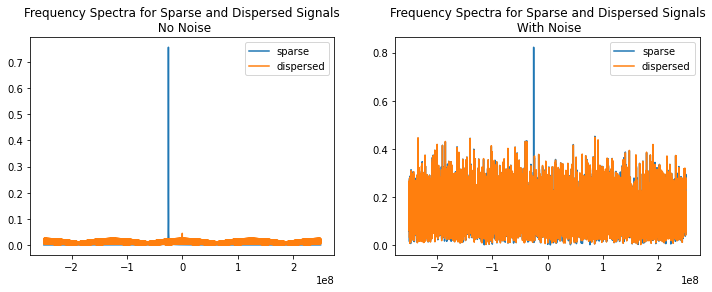

In [188]:
# fft, signal only
sparse_signal_F = np.fft.fft(sparse_signal) / num_samples
dispersed_signal_F = np.fft.fft(dispersed_signal) / num_samples
frequencies = np.fft.fftshift(np.fft.fftfreq(num_samples, dt))

# fft, signal + noise
sparse_signal_noise_F = np.fft.fft(sparse_signal + noise) / num_samples
dispersed_signal_noise_F = np.fft.fft(dispersed_signal + noise) / num_samples

#

fig1, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(frequencies, abs(np.fft.fftshift(sparse_signal_F)), label='sparse')
axs[0].plot(frequencies, abs(np.fft.fftshift(dispersed_signal_F)), label='dispersed')
axs[0].set_title('Frequency Spectra for Sparse and Dispersed Signals\n No Noise')
axs[0].legend()

axs[1].plot(frequencies, abs(np.fft.fftshift(sparse_signal_noise_F)), label='sparse')
axs[1].plot(frequencies, abs(np.fft.fftshift(dispersed_signal_noise_F)), label='dispersed')
axs[1].set_title('Frequency Spectra for Sparse and Dispersed Signals\n With Noise')
axs[1].legend()

## Time Series - Broadband Signal has Higher SNR

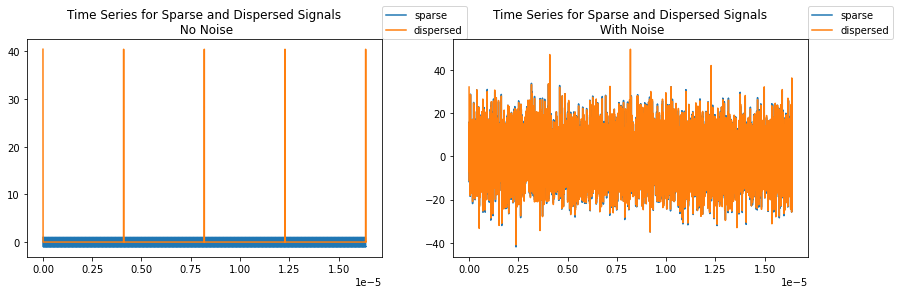

In [189]:
fig1, axs = plt.subplots(1, 2, figsize=(14,4))
axs[0].plot(time, np.real(sparse_signal), label='sparse')
axs[0].plot(time, np.real(dispersed_signal), label='dispersed')
axs[0].set_title('Time Series for Sparse and Dispersed Signals\n No Noise')
axs[0].legend(loc=(1,1))

axs[1].plot(time, np.real(sparse_signal + noise), label='sparse')
axs[1].plot(time, np.real(dispersed_signal + noise), label='dispersed')
axs[1].set_title('Time Series for Sparse and Dispersed Signals\n With Noise')
axs[1].legend(loc=(1,1))

# Matched Filter Approach

## Compare Full Convolution - Maximums are the same for both sparse and dispersed signals.

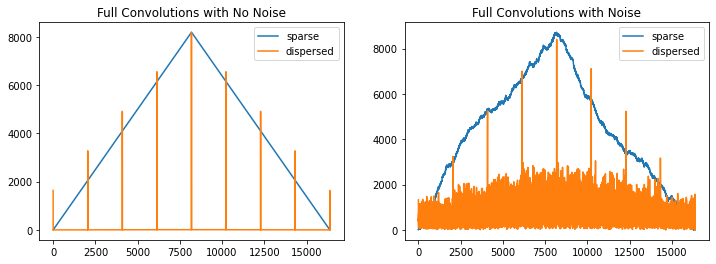

In [190]:
# calculate convolutions
sparse_conv = abs(np.convolve(sparse_signal, sparse_signal))
dispersed_conv = abs(np.convolve(dispersed_signal, dispersed_signal))

sparse_conv_noise = abs(np.convolve(sparse_signal, sparse_signal + noise))
dispersed_conv_noise = abs(np.convolve(dispersed_signal, dispersed_signal + noise))


fig1, axs = plt.subplots(1, 2, figsize=(12,4))
axs[0].plot(sparse_conv, label='sparse')
axs[0].plot(dispersed_conv, label='dispersed')
axs[0].set_title('Full Convolutions with No Noise')
axs[0].legend()

axs[1].plot(sparse_conv_noise, label='sparse')
axs[1].plot(dispersed_conv_noise, label='dispersed')
axs[1].set_title('Full Convolutions with Noise')
axs[1].legend()


## Experiment - Compute Matched Filter SNR for Sparse and Dispersed Signals

Text(0.5, 0, 'MF SNR')

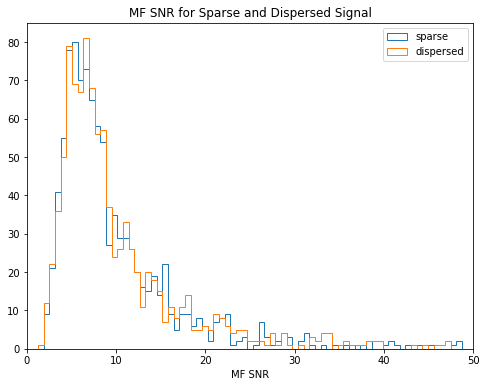

In [191]:
ntest = 1000
sparse_snr = []
dispersed_snr = []

for i in range(ntest):
    
    #if i % 100 == 99:
    #    print('Done with %.d tests' % (i + 1))

    noise = np.random.multivariate_normal([0, 0], np.eye(2) * noise_variance / 2, num_samples)
    noise = noise[:, 0] + 1j * noise[:, 1]

    sparse_signal_noise = noise + sparse_signal
    dispersed_signal_noise = noise + dispersed_signal

    # calculate SNR
    # SNR = (template \cdot signal) / (template \cdot noise_expectation)
    sparse_snr.append(abs(np.vdot(sparse_signal, sparse_signal_noise)) / abs(np.vdot(sparse_signal, noise)))
    dispersed_snr.append(abs(np.vdot(dispersed_signal, dispersed_signal_noise)) / abs(np.vdot(dispersed_signal, noise)))

plt.figure(figsize=(8,6))
plt.hist(sparse_snr, bins = np.linspace(0, 50, 80), histtype = 'step', label = 'sparse')
plt.hist(dispersed_snr, bins = np.linspace(0, 50, 80), histtype = 'step', label = 'dispersed')
plt.xlim(0, 50)
plt.legend(loc=0)
plt.title('MF SNR for Sparse and Dispersed Signal')
plt.xlabel('MF SNR')


# Result: The matched filter SNR for sparse and dispersed signals are the same. This is because the SNR for a matched filter is defined in terms of total signal power rather than the power in a specific frequency in the case of the FFT.

# Possible Implication: ATT optimization should seek to optimize recieved power since matched filter is agnositic to number of sidebands.